In [8]:
import matplotlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
from transformers import  BertTokenizer,DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import  AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn
from sklearn.model_selection import train_test_split
import os
import sys
import pandas as pd

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 


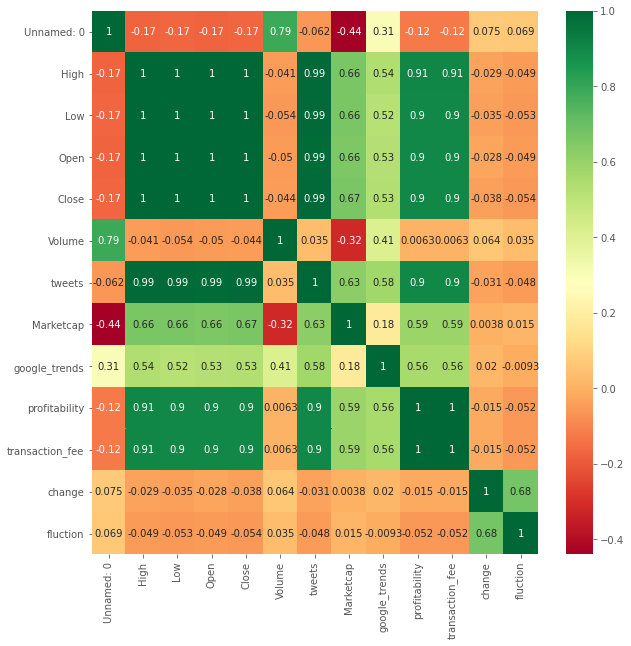

In [9]:
filepath = f"./data/ETH_Data.csv"

keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction']

targets = ["fluction"]
ETH_df = pd.read_csv(filepath, infer_datetime_format=True,
                         parse_dates=True)
ETH_df=ETH_df.fillna(0)
corrmat = ETH_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
ax=sns.heatmap(ETH_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

# top: "change","transaction_fee","profitablity","volume","tweets","google_trends","close"

In [10]:
ETH_df=ETH_df.set_index("Date")
#keys=['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction']
series = ETH_df[keys] 
# Picking the series with high correlation
print(series.shape)
series.tail(2)


(1009, 11)


,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,fluction
Date,,,,,,,,,,,
2020-12-13,593.781245,564.565993,568.609865,589.663222,9.070378e+09,6.711573e+10,7473.0,9.554,0.0340,0.0340,-0.00619
2020-12-14,590.492957,577.118432,589.782480,586.011152,8.125837e+09,6.670800e+10,6330.0,9.746,0.0385,0.0385,0.00000


## Price Predictions via three layers LSTM

In [11]:
%reload_ext autoreload
%autoreload 1
%aimport LSTM_pytorch
from sklearn.preprocessing import MinMaxScaler
from DataFun import plot_error,plot_data
import LSTM_pytorch


hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets',
         'Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction']
targets = ["fluction"]
# ["change","fluction"]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(filepath=filepath,
                                                              keys=keys,
                                                              batch_size=batch_size,
                                                              targets=targets,
                                                              output_dim=output_dim,
                                                              window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)




/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.42170626313790033. val_loss: 0.42862552912427737.
Epoch: 1. Loss: 0.39027260641873995. val_loss: 0.39770718478697625.
Epoch: 2. Loss: 0.3617229449637928. val_loss: 0.3674991914634413.
Epoch: 3. Loss: 0.3339254181392445. val_loss: 0.3411100389426548.
Epoch: 4. Loss: 0.3094625043572846. val_loss: 0.319247750791455.
Epoch: 5. Loss: 0.28705265840388233. val_loss: 0.2966847025232754.
Epoch: 6. Loss: 0.26570093659510524. val_loss: 0.27748314582370376.
Epoch: 7. Loss: 0.24636427067821812. val_loss: 0.25459900179074113.
Epoch: 8. Loss: 0.22735262426160138. val_loss: 0.23852031730660228.
Epoch: 9. Loss: 0.21010434544234544. val_loss: 0.22125574860204034.
Epoch: 10. Loss: 0.19450214310832645. val_loss: 0.2041437502011733.
Epoch: 11. Loss: 0.18023045050986805. val_loss: 0.1915746054505329.
Epoch: 12. Loss: 0.16697808970575748. val_loss: 0.178366364006399.
Epoch: 13. Loss: 0.15457886617098535. val_loss: 0.16718794202756096.
Epoch: 14. Loss: 0.14259640842398502. val_loss: 0.154004

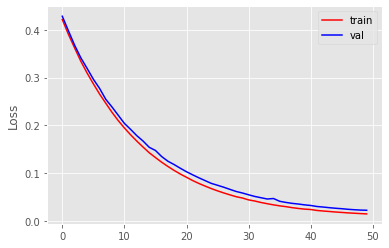

In [12]:

plot_error(train_loss,val_loss)

MSE = 0.027050722390413284
RMSE = 0.0
R-Squared Score = -72.05950988689439


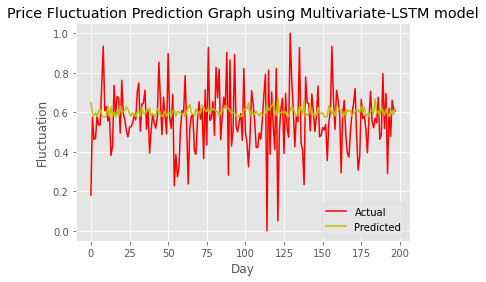

In [13]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

In [14]:
# # Save a model
#BTC_model.save('./model/LSTM_Vanilla_BTC.h5')
# #del model # Deletes the model
# # Load a model
# model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')

## price prediction model: three layer LSTM + sentiment indices from different "BERT" model

### LM

In [15]:
%reload_ext autoreload
%autoreload 1
%aimport LSTM_pytorch
from sklearn.preprocessing import MinMaxScaler
from DataFun import plot_error,plot_data
import LSTM_pytorch


hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

# keys = ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets',
#         'Marketcap', 'google_trends', 'profitability', 'transaction_fee',
#         'fluction']  # ,'change','Date']

# ["change","fluction"]
file_sentiment=f'./data/LM_dic_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [16]:
LM_df=pd.concat([df, sentiment['sentiment']], axis=1, join='inner')
keys = ['Close', 'Volume', 'tweets', 'google_trends', 'profitability', 'transaction_fee', 'fluction','sentiment']
targets = ["fluction"]
LM_df=LM_df[keys]
LM_df.tail(3)

,Close,Volume,tweets,google_trends,profitability,transaction_fee,fluction,sentiment
2020-12-12,568.567318,8.534558e+09,6.470694e+10,9.449,0.0328,0.0328,0.03710,0.020408
2020-12-13,589.663222,9.070378e+09,6.711573e+10,9.554,0.0340,0.0340,-0.00619,0.072727
2020-12-14,586.011152,8.125837e+09,6.670800e+10,9.746,0.0385,0.0385,0.00000,-0.051429


In [17]:

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=LM_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)

model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.17481627305851707. val_loss: 0.15331941492205717.
Epoch: 1. Loss: 0.16123442191489135. val_loss: 0.13966732658560893.
Epoch: 2. Loss: 0.1487782753626757. val_loss: 0.128762566354935.
Epoch: 3. Loss: 0.1372766449481626. val_loss: 0.11903622768689837.
Epoch: 4. Loss: 0.1269408370120616. val_loss: 0.10889094661756502.
Epoch: 5. Loss: 0.11837757991839058. val_loss: 0.10040473230922767.
Epoch: 6. Loss: 0.10841415525425839. val_loss: 0.0923383686327339.
Epoch: 7. Loss: 0.09996678159112417. val_loss: 0.085400846882705.
Epoch: 8. Loss: 0.09248527547320988. val_loss: 0.07870528890025427.
Epoch: 9. Loss: 0.08555792978245623. val_loss: 0.07258915137690819.
Epoch: 10. Loss: 0.07913620817133143. val_loss: 0.0670547927762386.
Epoch: 11. Loss: 0.07357982390477688. val_loss: 0.06196405070228794.
Epoch: 12. Loss: 0.06785301333646986. val_loss: 0.057441967968037244.
Epoch: 13. Loss: 0.06301865189135829. val_loss: 0.05325677448765229.
Epoch: 14. Loss: 0.058184244646396065. val_loss: 0.0

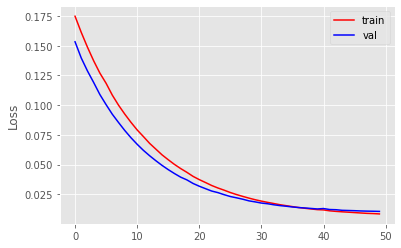

In [18]:
plot_error(train_loss,val_loss)

MSE = 0.0313398614525795
RMSE = 0.0
R-Squared Score = -67.0334464327675


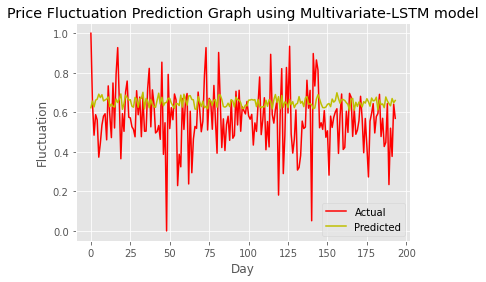

In [19]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

### RoBERTa

In [20]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

file_sentiment=f'./data/_roberta_fold_9_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [21]:
RoBERTa_df=pd.concat([df, sentiment],axis=1, join='inner')
RoBERTa_df.tail(3)

,Unnamed: 0,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,change,fluction,sentiment,preds
2020-12-12,1006,573.339444,545.245599,545.578562,568.567318,8.534558e+09,6.470694e+10,5604.0,9.449,0.0328,0.0328,1,0.03710,-0.030612,-0.171066
2020-12-13,1007,593.781245,564.565993,568.609865,589.663222,9.070378e+09,6.711573e+10,7473.0,9.554,0.0340,0.0340,0,-0.00619,0.045455,0.203180
2020-12-14,1008,590.492957,577.118432,589.782480,586.011152,8.125837e+09,6.670800e+10,6330.0,9.746,0.0385,0.0385,0,0.00000,0.185714,0.713161


#### sentiment without probability 

In [ ]:
keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction','sentiment']
targets = ["fluction"]
RoBERTa_df_sentiment=RoBERTa_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = 150)

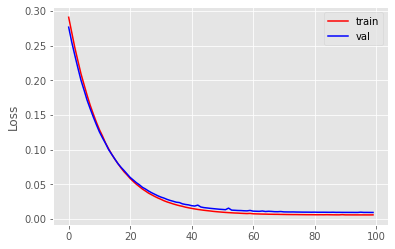

In [45]:
plot_error(train_loss,val_loss)

MSE = 0.034265536814928055
RMSE = 0.0
R-Squared Score = -82.7636185035884


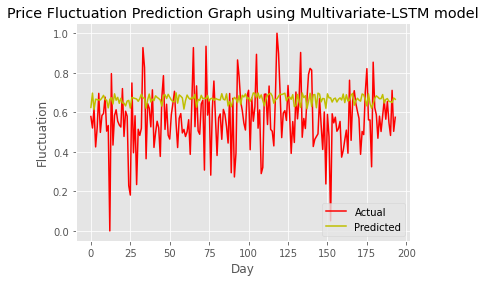

In [46]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

#### sentiment with probabilities


In [25]:
keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction','preds']
targets = ["fluction"]
RoBERTa_df_preds=RoBERTa_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.3581234963634346. val_loss: 0.3584095677099103.
Epoch: 1. Loss: 0.3321203887462616. val_loss: 0.3334595100628565.
Epoch: 2. Loss: 0.3085554006356227. val_loss: 0.31247831682130306.
Epoch: 3. Loss: 0.2879662496756904. val_loss: 0.2886514242282221.
Epoch: 4. Loss: 0.26679638669460637. val_loss: 0.2694376112556841.
Epoch: 5. Loss: 0.24802169816780695. val_loss: 0.2516415708847398.
Epoch: 6. Loss: 0.2295910854222654. val_loss: 0.23570858354622662.
Epoch: 7. Loss: 0.21398389815718313. val_loss: 0.219450598344818.
Epoch: 8. Loss: 0.1991302664332752. val_loss: 0.20386253896556825.
Epoch: 9. Loss: 0.18509230413768865. val_loss: 0.19035670710848904.
Epoch: 10. Loss: 0.17222618835070466. val_loss: 0.17782959576052895.
Epoch: 11. Loss: 0.16029340915287596. val_loss: 0.1656458348719199.
Epoch: 12. Loss: 0.1494203516859797. val_loss: 0.15553254549382572.
Epoch: 13. Loss: 0.138559497515612. val_loss: 0.14685933998657738.
Epoch: 14. Loss: 0.12933945844445047. val_loss: 0.13526440626

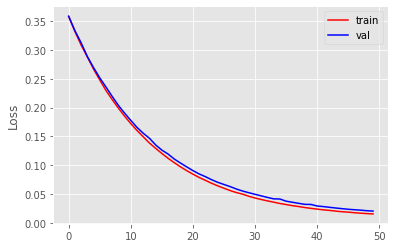

In [26]:
plot_error(train_loss,val_loss)

MSE = 0.029304351657629013
RMSE = 0.0
R-Squared Score = -14.94272777134927


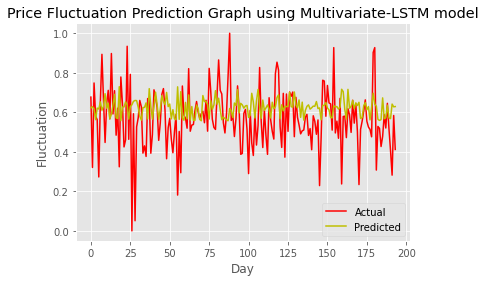

In [27]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

### DistilBERT


In [28]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

file_sentiment=f'./data/_distilbert_fold_2_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [29]:
Distil_df=pd.concat([df, sentiment],axis=1, join='inner')
Distil_df.tail(3)

,Unnamed: 0,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,change,fluction,sentiment,preds
2020-12-12,1006,573.339444,545.245599,545.578562,568.567318,8.534558e+09,6.470694e+10,5604.0,9.449,0.0328,0.0328,1,0.03710,0.051020,0.076313
2020-12-13,1007,593.781245,564.565993,568.609865,589.663222,9.070378e+09,6.711573e+10,7473.0,9.554,0.0340,0.0340,0,-0.00619,0.054545,0.133536
2020-12-14,1008,590.492957,577.118432,589.782480,586.011152,8.125837e+09,6.670800e+10,6330.0,9.746,0.0385,0.0385,0,0.00000,0.100000,0.269738


#### sentiment without probabilities

In [30]:
keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction','sentiment']
targets = ["fluction"]
Distil_df_sentiment=Distil_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=Distil_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.27516029143257986. val_loss: 0.2567430023712346.
Epoch: 1. Loss: 0.2543685316473623. val_loss: 0.23735109711794103.
Epoch: 2. Loss: 0.23487094393636607. val_loss: 0.21959862357736118.
Epoch: 3. Loss: 0.21676841538540925. val_loss: 0.20236112701586212.
Epoch: 4. Loss: 0.20074909529354. val_loss: 0.18761298868960102.
Epoch: 5. Loss: 0.18521350471279288. val_loss: 0.17520060485350153.
Epoch: 6. Loss: 0.1710875095634521. val_loss: 0.16013042701562435.
Epoch: 7. Loss: 0.1583221259562275. val_loss: 0.1485547122259148.
Epoch: 8. Loss: 0.14627011978550802. val_loss: 0.13924293803799856.
Epoch: 9. Loss: 0.13535365405716474. val_loss: 0.1295275670155707.
Epoch: 10. Loss: 0.12553865726612792. val_loss: 0.11768918019783847.
Epoch: 11. Loss: 0.11575076236283477. val_loss: 0.10950637403436003.
Epoch: 12. Loss: 0.1072712145227043. val_loss: 0.10113503750316857.
Epoch: 13. Loss: 0.09959528656511367. val_loss: 0.09408616845750388.
Epoch: 14. Loss: 0.09183486513321913. val_loss: 0.0873

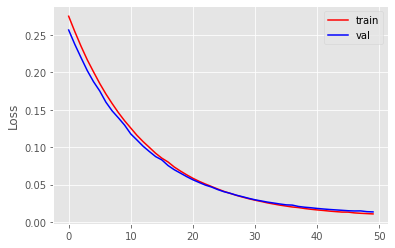

In [31]:
plot_error(train_loss,val_loss)

MSE = 0.02661578170955181
RMSE = 0.0
R-Squared Score = -132.9947186140178


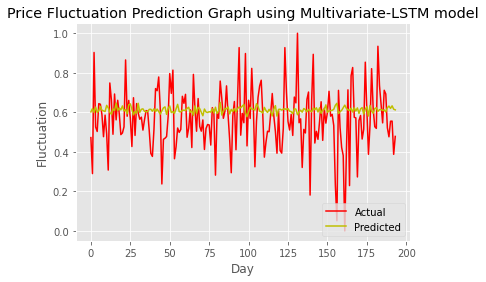

In [32]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

#### sentiment with probabilities

In [33]:
keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction','preds']
targets = ["fluction"]
Distil_df_preds=Distil_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=RoBERTa_df,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.38080750933930846. val_loss: 0.3771273682554383.
Epoch: 1. Loss: 0.3520440168773072. val_loss: 0.34973051329062643.
Epoch: 2. Loss: 0.32603042035163204. val_loss: 0.3229964138085753.
Epoch: 3. Loss: 0.3015438111711152. val_loss: 0.29895874192540167.
Epoch: 4. Loss: 0.28038725964253464. val_loss: 0.27680617422880716.
Epoch: 5. Loss: 0.25825819231664077. val_loss: 0.25629866718981636.
Epoch: 6. Loss: 0.23906364508821995. val_loss: 0.2373466548504803.
Epoch: 7. Loss: 0.2209150356393826. val_loss: 0.22209022742317455.
Epoch: 8. Loss: 0.20428525444261636. val_loss: 0.20372300679770555.
Epoch: 9. Loss: 0.1891100085045718. val_loss: 0.18845469988935157.
Epoch: 10. Loss: 0.17492391824533668. val_loss: 0.174770001094616.
Epoch: 11. Loss: 0.16196756621327582. val_loss: 0.16385025483501803.
Epoch: 12. Loss: 0.1500875685788408. val_loss: 0.14989489146478752.
Epoch: 13. Loss: 0.13948626604072656. val_loss: 0.13958933460597645.
Epoch: 14. Loss: 0.12834619235577463. val_loss: 0.1290

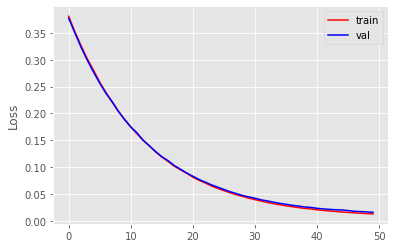

In [34]:
plot_error(train_loss,val_loss)

MSE = 0.025202013552188873
RMSE = 0.0
R-Squared Score = -66.12383470087354


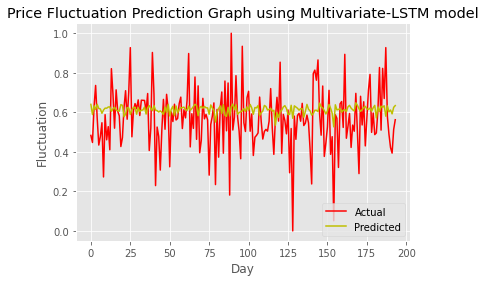

In [35]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

### FinBERT

In [36]:

hidden_dim = 20
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO N LAYER
output_dim = 1  # 2
seq_dim = 3
batch_size = 4
num_epochs = 150

file_sentiment=f'./data/FinBert_pre_sentiment.csv'
df = pd.read_csv(filepath, infer_datetime_format=True,parse_dates=True)
sentiment=pd.read_csv(file_sentiment, infer_datetime_format=True,parse_dates=True)
sentiment=sentiment.set_index('date')
df=df.set_index('Date')

In [37]:
FinBERT_df=pd.concat([df, sentiment],axis=1, join='inner')
FinBERT_df.tail(3)

,Unnamed: 0,High,Low,Open,Close,Volume,tweets,Marketcap,google_trends,profitability,transaction_fee,change,fluction,sentiment,preds
2020-12-12,1006,573.339444,545.245599,545.578562,568.567318,8.534558e+09,6.470694e+10,5604.0,9.449,0.0328,0.0328,1,0.03710,-0.010204,-0.112530
2020-12-13,1007,593.781245,564.565993,568.609865,589.663222,9.070378e+09,6.711573e+10,7473.0,9.554,0.0340,0.0340,0,-0.00619,-0.009091,-0.033573
2020-12-14,1008,590.492957,577.118432,589.782480,586.011152,8.125837e+09,6.670800e+10,6330.0,9.746,0.0385,0.0385,0,0.00000,0.000000,-0.066098


#### sentiment without probability

In [38]:
keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction','sentiment']
targets = ["fluction"]
FinBERT_df_sentiment=FinBERT_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=FinBERT_df_sentiment,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.5623394848802422. val_loss: 0.5830459630955616.
Epoch: 1. Loss: 0.514972553034372. val_loss: 0.5430727194984002.
Epoch: 2. Loss: 0.4754310231420058. val_loss: 0.498633095706878.
Epoch: 3. Loss: 0.4378893535725678. val_loss: 0.46154952246596237.
Epoch: 4. Loss: 0.40308434299275847. val_loss: 0.4270707733125959.
Epoch: 5. Loss: 0.3705751548839521. val_loss: 0.3957396292208406.
Epoch: 6. Loss: 0.3416395925834209. val_loss: 0.3668451846667322.
Epoch: 7. Loss: 0.31480274858731255. val_loss: 0.33890268996538514.
Epoch: 8. Loss: 0.2901055850560152. val_loss: 0.3141565214025769.
Epoch: 9. Loss: 0.2668974079851863. val_loss: 0.2906020309593863.
Epoch: 10. Loss: 0.24669090149146092. val_loss: 0.26991781108595536.
Epoch: 11. Loss: 0.22632711993742594. val_loss: 0.249447429418112.
Epoch: 12. Loss: 0.20798737659484526. val_loss: 0.2319651183775778.
Epoch: 13. Loss: 0.19186599293275725. val_loss: 0.21515615970179297.
Epoch: 14. Loss: 0.17692884821680527. val_loss: 0.199531678299339

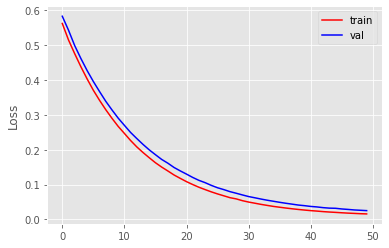

In [39]:
plot_error(train_loss,val_loss)

MSE = 0.029692059382796288
RMSE = 0.0
R-Squared Score = -10.569637641517925


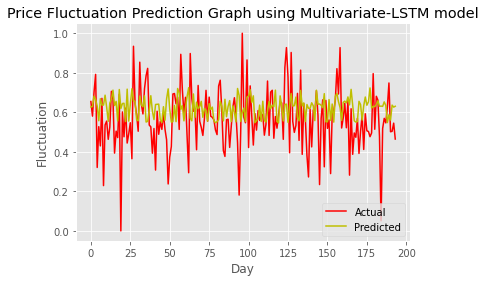

In [40]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)

#### sentiment with probabilities

In [41]:
keys =  ['High', 'Low', 'Open', 'Close', 'Volume', 'tweets','Marketcap', 'google_trends',
        'profitability', 'transaction_fee','fluction','preds']
targets = ["fluction"]
FinBERT_df_preds=FinBERT_df[keys]

scaler=MinMaxScaler()
(input_dim, train_dataset, train_loader, val_dataset,
 val_loader, test_dataset, scaler) = LSTM_pytorch.dataloading(
                                                    df=FinBERT_df_preds,
                                                    keys=keys,
                                                    batch_size=batch_size,
                                                    targets=targets,
                                                    output_dim=output_dim,
                                                    window_size=seq_dim)
#LSTM(input_dim,train_loader, val_loader, hidden_dim, layer_dim, output_dim, seq_dim=7):
 
model,train_loss,val_loss = LSTM_pytorch.LSTM(input_dim=input_dim,
                                                 seq_dim=seq_dim,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 hidden_dim=hidden_dim,
                                                 layer_dim=layer_dim,
                                                 output_dim=output_dim,
                                                 num_epochs = num_epochs)

/vol/fob-vol7/nebenf19/dingneng/ding_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0. Loss: 0.39532695823832403. val_loss: 0.39388216729575254.
Epoch: 1. Loss: 0.3637630715023113. val_loss: 0.3651513854440192.
Epoch: 2. Loss: 0.33549423478072204. val_loss: 0.3368821752980086.
Epoch: 3. Loss: 0.308808272492282. val_loss: 0.31368114988897117.
Epoch: 4. Loss: 0.2844084030653857. val_loss: 0.2891461552844126.
Epoch: 5. Loss: 0.26201153197620486. val_loss: 0.267905806231883.
Epoch: 6. Loss: 0.24164225736373587. val_loss: 0.24761232565515456.
Epoch: 7. Loss: 0.22231070192742952. val_loss: 0.22987395818899764.
Epoch: 8. Loss: 0.20460844624646102. val_loss: 0.21328113057948656.
Epoch: 9. Loss: 0.1886499566556532. val_loss: 0.19723523098595414.
Epoch: 10. Loss: 0.17419549426700495. val_loss: 0.1831704799155301.
Epoch: 11. Loss: 0.16069744475468806. val_loss: 0.17023053044916253.
Epoch: 12. Loss: 0.14833766486071334. val_loss: 0.1572703213455358.
Epoch: 13. Loss: 0.1364329593562627. val_loss: 0.14706073458773922.
Epoch: 14. Loss: 0.12619808745346492. val_loss: 0.1364215

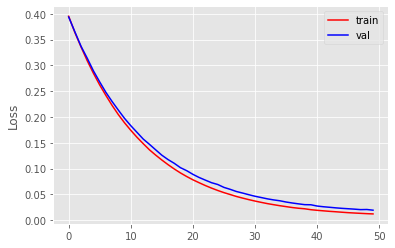

In [42]:
plot_error(train_loss,val_loss)

MSE = 0.025923626497387886
RMSE = 0.0
R-Squared Score = -131.33744985427145


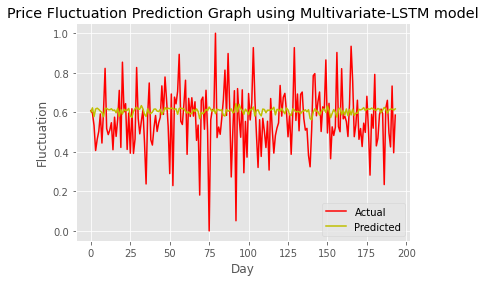

In [43]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)
predicted, actual, mse, r, rmse = LSTM_pytorch.LSTM_predict(test_loader, model)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r))
plot_data(actual,predicted)